# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


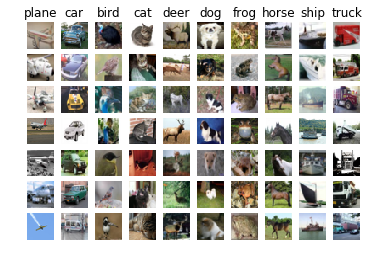

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


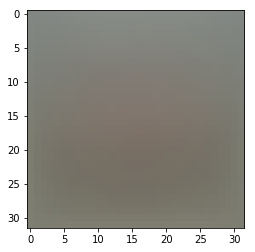

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.083265


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 13.220605 analytic: 6610.302408, relative error: 9.960080e-01
numerical: -42.235701 analytic: -21117.850449, relative error: 9.960080e-01
numerical: 31.970290 analytic: 15985.144898, relative error: 9.960080e-01
numerical: 22.874451 analytic: 11437.225714, relative error: 9.960080e-01
numerical: 14.413686 analytic: 7190.605755, relative error: 9.959990e-01
numerical: -17.011503 analytic: -8522.811265, relative error: 9.960160e-01
numerical: 3.720149 analytic: 1860.074694, relative error: 9.960080e-01
numerical: 39.084937 analytic: 19542.468286, relative error: 9.960080e-01
numerical: 11.104953 analytic: 5540.573306, relative error: 9.959994e-01
numerical: -3.160545 analytic: -1580.272571, relative error: 9.960080e-01
numerical: -1.259172 analytic: -627.546429, relative error: 9.959950e-01
numerical: -26.284976 analytic: -13139.964571, relative error: 9.960072e-01
numerical: -40.494434 analytic: -20247.797469, relative error: 9.960081e-01
numerical: 19.868179 analytic: 9940.0

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ The numerical gradient is usually the same as the analytical gradient for a linear function, as (f(x + h) - f(x)) / h essentially equals the slope. Howover, f(x) = max(0, x) introduces a hinge at x = 0. If the margin is negative and |margin| < |h|, the numerical gradient would not be equal to the analytical gradient (analytical = 0, numerical > 0 because f(margin + h) > 0). Increasing the margin could decrease the frequency of this happening by decreasing the chance of the margin being close to 0.


In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.083265e+00 computed in 0.227006s
Vectorized loss: 9.083265e+00 computed in 0.005022s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.196996s
Vectorized loss and gradient: computed in 0.006024s
difference: 1734878.642715


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 405.569009
iteration 100 / 1500: loss 241.276146
iteration 200 / 1500: loss 148.147680
iteration 300 / 1500: loss 91.315587
iteration 400 / 1500: loss 56.647209
iteration 500 / 1500: loss 35.140501
iteration 600 / 1500: loss 24.097259
iteration 700 / 1500: loss 16.349703
iteration 800 / 1500: loss 11.870313
iteration 900 / 1500: loss 9.261147
iteration 1000 / 1500: loss 7.719020
iteration 1100 / 1500: loss 6.750948
iteration 1200 / 1500: loss 5.987822
iteration 1300 / 1500: loss 5.489815
iteration 1400 / 1500: loss 5.184932
That took 10.903997s


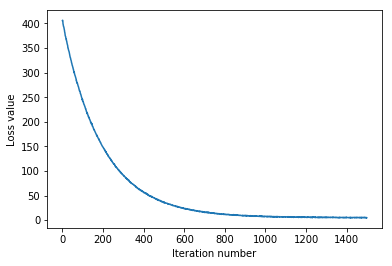

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379980
validation accuracy: 0.395000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-8, 1.7e-8, 3e-8, 5e-8, 1e-7, 1.7e-7, 3e-7, 5e-7, 1e-6, 1.7e-6]
regularization_strengths = [1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
# learning_rates = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6]
# regularization_strengths = [3e3, 1e4, 3e4, 1e5, 3e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for rate in learning_rates:
    for strength in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=strength,
                      num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print(train_accuracy)
        print(val_accuracy)
        print()
        results[(rate, strength)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = svm
        # print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 22.682790
iteration 100 / 2000: loss 18.769225
iteration 200 / 2000: loss 17.003795
iteration 300 / 2000: loss 15.690171
iteration 400 / 2000: loss 16.890145
iteration 500 / 2000: loss 16.276540
iteration 600 / 2000: loss 15.020435
iteration 700 / 2000: loss 13.686853
iteration 800 / 2000: loss 11.960309
iteration 900 / 2000: loss 13.030837
iteration 1000 / 2000: loss 12.476486
iteration 1100 / 2000: loss 11.974130
iteration 1200 / 2000: loss 13.399153
iteration 1300 / 2000: loss 12.977646
iteration 1400 / 2000: loss 11.815728
iteration 1500 / 2000: loss 11.501544
iteration 1600 / 2000: loss 10.985892
iteration 1700 / 2000: loss 9.720916
iteration 1800 / 2000: loss 11.426102
iteration 1900 / 2000: loss 9.449160
0.231
0.228

iteration 0 / 2000: loss 29.879476
iteration 100 / 2000: loss 21.747957
iteration 200 / 2000: loss 20.070912
iteration 300 / 2000: loss 19.125074
iteration 400 / 2000: loss 18.581192
iteration 500 / 2000: loss 17.526261
iteration 600 / 2000:

iteration 1100 / 2000: loss 24.181251
iteration 1200 / 2000: loss 22.798462
iteration 1300 / 2000: loss 23.646325
iteration 1400 / 2000: loss 25.611472
iteration 1500 / 2000: loss 22.888172
iteration 1600 / 2000: loss 22.089299
iteration 1700 / 2000: loss 21.699099
iteration 1800 / 2000: loss 24.086743
iteration 1900 / 2000: loss 21.138827
0.2560408163265306
0.276

iteration 0 / 2000: loss 67.406840
iteration 100 / 2000: loss 63.383476
iteration 200 / 2000: loss 60.896437
iteration 300 / 2000: loss 60.122164
iteration 400 / 2000: loss 58.492636
iteration 500 / 2000: loss 53.988563
iteration 600 / 2000: loss 55.248139
iteration 700 / 2000: loss 54.925459
iteration 800 / 2000: loss 53.244107
iteration 900 / 2000: loss 51.577790
iteration 1000 / 2000: loss 51.213505
iteration 1100 / 2000: loss 51.296327
iteration 1200 / 2000: loss 49.840836
iteration 1300 / 2000: loss 48.329741
iteration 1400 / 2000: loss 48.588507
iteration 1500 / 2000: loss 46.910866
iteration 1600 / 2000: loss 47.95801

iteration 200 / 2000: loss 332.294221
iteration 300 / 2000: loss 277.171104
iteration 400 / 2000: loss 231.094144
iteration 500 / 2000: loss 193.315146
iteration 600 / 2000: loss 162.675180
iteration 700 / 2000: loss 135.634297
iteration 800 / 2000: loss 114.639134
iteration 900 / 2000: loss 95.862815
iteration 1000 / 2000: loss 80.959392
iteration 1100 / 2000: loss 68.116707
iteration 1200 / 2000: loss 57.402798
iteration 1300 / 2000: loss 48.813375
iteration 1400 / 2000: loss 41.873871
iteration 1500 / 2000: loss 35.621421
iteration 1600 / 2000: loss 30.729606
iteration 1700 / 2000: loss 26.156650
iteration 1800 / 2000: loss 23.193269
iteration 1900 / 2000: loss 19.462212
0.360265306122449
0.364

iteration 0 / 2000: loss 1543.525249
iteration 100 / 2000: loss 842.098357
iteration 200 / 2000: loss 463.753054
iteration 300 / 2000: loss 255.953926
iteration 400 / 2000: loss 142.394126
iteration 500 / 2000: loss 80.239974
iteration 600 / 2000: loss 46.062969
iteration 700 / 2000: loss 28

iteration 1500 / 2000: loss 5.984700
iteration 1600 / 2000: loss 5.935155
iteration 1700 / 2000: loss 6.034221
iteration 1800 / 2000: loss 6.360771
iteration 1900 / 2000: loss 5.856148
0.3398775510204082
0.355

iteration 0 / 2000: loss 26.236622
iteration 100 / 2000: loss 12.004448
iteration 200 / 2000: loss 11.637671
iteration 300 / 2000: loss 11.457643
iteration 400 / 2000: loss 9.254677
iteration 500 / 2000: loss 10.435287
iteration 600 / 2000: loss 9.798062
iteration 700 / 2000: loss 9.464739
iteration 800 / 2000: loss 8.910576
iteration 900 / 2000: loss 8.589796
iteration 1000 / 2000: loss 7.471113
iteration 1100 / 2000: loss 8.563178
iteration 1200 / 2000: loss 7.258026
iteration 1300 / 2000: loss 8.246981
iteration 1400 / 2000: loss 8.100383
iteration 1500 / 2000: loss 7.165534
iteration 1600 / 2000: loss 8.133547
iteration 1700 / 2000: loss 8.326567
iteration 1800 / 2000: loss 7.449231
iteration 1900 / 2000: loss 7.475191
0.3167755102040816
0.316

iteration 0 / 2000: loss 29.48

iteration 1000 / 2000: loss 16.658610
iteration 1100 / 2000: loss 16.603402
iteration 1200 / 2000: loss 16.233037
iteration 1300 / 2000: loss 14.739093
iteration 1400 / 2000: loss 14.365660
iteration 1500 / 2000: loss 14.222767
iteration 1600 / 2000: loss 13.698851
iteration 1700 / 2000: loss 13.218918
iteration 1800 / 2000: loss 12.618073
iteration 1900 / 2000: loss 13.242634
0.34959183673469385
0.351

iteration 0 / 2000: loss 65.808645
iteration 100 / 2000: loss 51.058348
iteration 200 / 2000: loss 45.868722
iteration 300 / 2000: loss 39.754288
iteration 400 / 2000: loss 37.469095
iteration 500 / 2000: loss 33.019439
iteration 600 / 2000: loss 30.088210
iteration 700 / 2000: loss 27.472158
iteration 800 / 2000: loss 24.978093
iteration 900 / 2000: loss 22.552895
iteration 1000 / 2000: loss 21.264428
iteration 1100 / 2000: loss 18.852841
iteration 1200 / 2000: loss 17.918919
iteration 1300 / 2000: loss 16.601334
iteration 1400 / 2000: loss 15.167492
iteration 1500 / 2000: loss 13.8418

iteration 500 / 2000: loss 5.570400
iteration 600 / 2000: loss 5.391236
iteration 700 / 2000: loss 5.014777
iteration 800 / 2000: loss 5.250706
iteration 900 / 2000: loss 5.935673
iteration 1000 / 2000: loss 5.142606
iteration 1100 / 2000: loss 4.977277
iteration 1200 / 2000: loss 4.573355
iteration 1300 / 2000: loss 5.862242
iteration 1400 / 2000: loss 5.470641
iteration 1500 / 2000: loss 5.445877
iteration 1600 / 2000: loss 5.483938
iteration 1700 / 2000: loss 5.059356
iteration 1800 / 2000: loss 5.161212
iteration 1900 / 2000: loss 5.283381
0.3458775510204082
0.366

iteration 0 / 2000: loss 1557.098519
iteration 100 / 2000: loss 9.714614
iteration 200 / 2000: loss 5.675070
iteration 300 / 2000: loss 5.631902
iteration 400 / 2000: loss 5.395619
iteration 500 / 2000: loss 6.176630
iteration 600 / 2000: loss 5.665548
iteration 700 / 2000: loss 5.455116
iteration 800 / 2000: loss 5.702847
iteration 900 / 2000: loss 5.324850
iteration 1000 / 2000: loss 5.632263
iteration 1100 / 2000: los

iteration 100 / 2000: loss 10.227285
iteration 200 / 2000: loss 8.392392
iteration 300 / 2000: loss 7.412555
iteration 400 / 2000: loss 7.088063
iteration 500 / 2000: loss 6.780938
iteration 600 / 2000: loss 7.253312
iteration 700 / 2000: loss 6.982019
iteration 800 / 2000: loss 6.205825
iteration 900 / 2000: loss 6.482041
iteration 1000 / 2000: loss 5.591348
iteration 1100 / 2000: loss 5.772222
iteration 1200 / 2000: loss 6.832519
iteration 1300 / 2000: loss 5.978204
iteration 1400 / 2000: loss 5.606484
iteration 1500 / 2000: loss 5.553922
iteration 1600 / 2000: loss 5.359407
iteration 1700 / 2000: loss 5.085792
iteration 1800 / 2000: loss 6.215644
iteration 1900 / 2000: loss 6.081389
0.35942857142857143
0.339

iteration 0 / 2000: loss 23.752602
iteration 100 / 2000: loss 11.375998
iteration 200 / 2000: loss 10.328858
iteration 300 / 2000: loss 9.564863
iteration 400 / 2000: loss 9.481399
iteration 500 / 2000: loss 8.569323
iteration 600 / 2000: loss 8.884918
iteration 700 / 2000: los

iteration 1800 / 2000: loss 6.397769
iteration 1900 / 2000: loss 6.837036
0.32193877551020406
0.315

iteration 0 / 2000: loss 77.203516
iteration 100 / 2000: loss 22.598753
iteration 200 / 2000: loss 12.851691
iteration 300 / 2000: loss 7.791693
iteration 400 / 2000: loss 7.912783
iteration 500 / 2000: loss 7.127999
iteration 600 / 2000: loss 6.017997
iteration 700 / 2000: loss 6.781197
iteration 800 / 2000: loss 6.494823
iteration 900 / 2000: loss 7.136366
iteration 1000 / 2000: loss 9.115629
iteration 1100 / 2000: loss 4.996517
iteration 1200 / 2000: loss 7.094366
iteration 1300 / 2000: loss 6.094175
iteration 1400 / 2000: loss 6.683545
iteration 1500 / 2000: loss 6.403111
iteration 1600 / 2000: loss 6.311617
iteration 1700 / 2000: loss 6.549517
iteration 1800 / 2000: loss 5.618443
iteration 1900 / 2000: loss 6.869944
0.3460408163265306
0.336

iteration 0 / 2000: loss 179.742484
iteration 100 / 2000: loss 10.929561
iteration 200 / 2000: loss 7.078021
iteration 300 / 2000: loss 7.6908

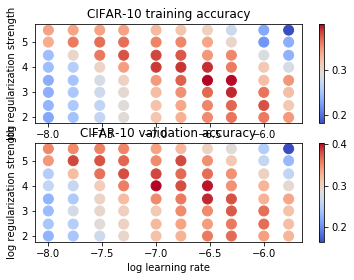

In [15]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


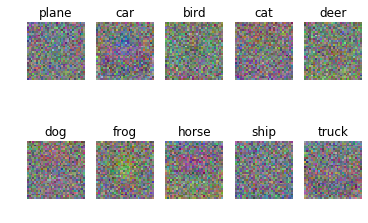

In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

#### **Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ Many of the visualized weights almost seem to represent the labels themselves. This is because they are tuned by the training set such that they can generate the maximum scores for objects that match the weights but minimum scores for other objects. Their most prominent features, then represent the most prominent features of the images they were trained with (so the pixel magnitudes of these prominent features can be multiplied together to generate a higher score).
